### Portafolio mínima varianza, frontera eficiente, portafolio óptimo y simulación de retornos

El objetivo de este Jupyter es proporcionar una guía sobre cómo obtener el portafolio de mínima varianza, la frontera eficiente y el portafolio óptimo de una cartera, así como simular sus retornos utilizando Python

<details>
    <summary>Resultado final</summary>
    <img src="img/dashboard.png" width="800" height="600"/>
</details>

#### Librerías

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Ajuste para imprimir numpy arrays como %
np.set_printoptions(formatter={"float": lambda x: "{:.2f}%".format(x * 100)})

#### Tickers y data

Definimos y obtenemos los tickers

In [2]:
tickers_list = ["MPC", "MSFT", "COKE", "TSLA", "GC=F"]
tickers = yf.Tickers(tickers_list)

Obtenemos los precios de cierre históricos de un periodo de 5 años con intervalo diario

In [3]:
tickers_data = tickers.history(period="5y", interval="1d")
tickers_data = pd.DataFrame(tickers_data).dropna()
tickers_data = tickers_data["Close"]

[*********************100%***********************]  5 of 5 completed


#### Retornos y covarianza

Obtenemos los retornos diarios, promediamos y anualizamos, obtenemos también la covarianza sobre los retornos diarios y anualizamos

In [4]:
portfolio_returns = tickers_data.pct_change().dropna()
portfolio_mean_returns = portfolio_returns.mean() * 252
cov_matrix = portfolio_returns.cov() * 252

#### Funciones de riesgo y rendimiento

Definimos la funciones para obtener mediante matrices retorno, riesgo y Sharpe (en negativo para proximamente obtener el máximo minimizando)

In [5]:
def portfolio_return(weights):
    return np.dot(weights, portfolio_mean_returns)

def portfolio_risk(weights):
    axis = np.ndim(weights) - 1
    return np.sqrt(np.sum(np.dot(weights, cov_matrix) * weights, axis=axis))

def portfolio_sharpe(weights):
    rf_rate = 0.05
    return -(portfolio_return(weights) - rf_rate)/portfolio_risk(weights)

#### Función de mínima varianza

Definimos la función para encontrar la mínima varianza al minimizar la función de riesgo de portafolio, tenemos dos restricciones, la suma de todos los pesos debe ser igual a 1 (y estos se deben encontrar entre 0 y 1) y los retornos deben ser mayor o igual a la variable mínimo retorno, esto para poder diseñar proximamente la frontera eficiente

In [6]:
n_stocks = len(tickers_list)
init_weights = np.ones(n_stocks)/n_stocks

def min_variance(min_return):
    bounds = ((0,1) for _ in range(n_stocks))
    
    constraints = [
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},
        {"type": "ineq", "fun": lambda w: portfolio_return(w) - min_return}
    ]
    
    optimal = minimize(portfolio_risk, init_weights, method="SLSQP", bounds=bounds, constraints=constraints)

    return optimal.x

#### Portafolio de mínima varianza

In [7]:
min_variance_weights = min_variance(0)

min_variance_portfolio = pd.Series(
    [
        portfolio_return(min_variance_weights),
        portfolio_risk(min_variance_weights),
        -portfolio_sharpe(min_variance_weights)
    ],
    index=["Retorno", "Riesgo", "Sharpe"]
)

print(min_variance_portfolio.to_string())
print(min_variance_weights)

Retorno    0.175475
Riesgo     0.141656
Sharpe     0.885772
[7.11% 75.13% 4.11% 13.65% 0.00%]


#### Función para obtener la frontera eficiente

Definimos la función para obtener la frontera eficiente, con n portafolios eficientes, linspace sería n retornos entre el mínimo y máximo de la media de retornos anualizados de los activos del portafolio, queremos econtrar el portafolio con menor riesgo dado "x" retorno (recordar que en la función que definimos para mínima varianza, el retorno debe ser mayor o igual a "x")

In [8]:
def get_ef_line(n):
    linspace = np.linspace(portfolio_mean_returns.min(), portfolio_mean_returns.max(), n)

    weights = []
    
    for r in linspace:
        weights.append(min_variance(r))

    return np.array(weights)

#### Portafolios que forman la frontera eficiente

In [9]:
ef_line_weights = get_ef_line(100)

ef_line = pd.DataFrame(
    {
        "Retorno": portfolio_return(ef_line_weights),
        "Riesgo": portfolio_risk(ef_line_weights),
        "Sharpe": -portfolio_sharpe(ef_line_weights)
    }
)

print(ef_line)

     Retorno    Riesgo    Sharpe
0   0.175475  0.141656  0.885772
1   0.175475  0.141656  0.885772
2   0.175475  0.141656  0.885772
3   0.175475  0.141656  0.885772
4   0.175475  0.141656  0.885772
..       ...       ...       ...
95  0.701551  0.619882  1.051089
96  0.707579  0.629808  1.044094
97  0.713607  0.639819  1.037179
98  0.719635  0.649911  1.030348
99  0.725663  0.660081  1.023606

[100 rows x 3 columns]


#### Simulación de portafolios posibles

Definimos la función para simular los pesos (aleatorios) de cada activo en "n" cantidad de portafolios, usamos dirichlet para obtener "n" filas (portafolios) de matriz con "n_stocks" columnas (activos) que contiene los pesos para cada activo que sumados sean igual a 1 (100%)

In [10]:
def simulate_portfolios(n):
    rng = np.random.default_rng()
    weights = rng.dirichlet(np.ones(n_stocks), size=n)

    simulated_portfolios = pd.DataFrame(
        {
            "Retorno": portfolio_return(weights),
            "Riesgo": portfolio_risk(weights),
            "Sharpe": -portfolio_sharpe(weights)
        }
    )

    return simulated_portfolios

#### Portafolios simulados

In [11]:
simulated_portfolios = simulate_portfolios(200000)

print(simulated_portfolios[["Sharpe", "Retorno", "Riesgo"]].sort_values(by="Sharpe", ascending=False))

          Sharpe   Retorno    Riesgo
189013  1.298663  0.331358  0.216652
112236  1.298483  0.339530  0.222976
84446   1.297853  0.330499  0.216125
139818  1.297776  0.325036  0.211929
130038  1.297610  0.339309  0.222955
...          ...       ...       ...
73366   0.616399  0.319788  0.437684
158985  0.604003  0.142647  0.153389
92934   0.600234  0.322754  0.454413
80491   0.588558  0.141374  0.155251
9151    0.586876  0.140257  0.153793

[200000 rows x 3 columns]


#### Función para maximizar Sharpe

Definimos la función para maximizar (minimizar el negativo) Sharpe, similar a la de mínima varianza

In [12]:
def max_sharpe():
    bounds = ((0,1) for _ in range(n_stocks))
    
    constraints = [
        {"type": "eq", "fun": lambda w: np.sum(w) - 1}
    ]
    
    optimal = minimize(portfolio_sharpe, init_weights, method="SLSQP", bounds=bounds, constraints=constraints)

    return optimal.x

#### Portafolio óptimo

In [13]:
max_sharpe_weights = max_sharpe()

max_sharpe_portfolio = pd.Series(
    [
        portfolio_return(max_sharpe_weights),
        portfolio_risk(max_sharpe_weights),
        -portfolio_sharpe(max_sharpe_weights)
    ],
    index=["Retorno", "Riesgo", "Sharpe"]
)

print(max_sharpe_portfolio.to_string())
print(max_sharpe_weights)

Retorno    0.333575
Riesgo     0.218315
Sharpe     1.298926
[23.72% 41.34% 8.89% 6.66% 19.39%]


#### Simular retornos

Definimos una función para simular los retornos futuros de los activos y obtenemos sus retornos acumulados, para esto generamos retornos aleatorios a través de una distribución normal multivariada con medias el promedio de retornos de cada activo y covarianza la matriz de covarianza entre estos

In [14]:
def simulate_returns(n, weights):
    days = 252

    daily_returns_log = np.log1p(portfolio_returns)
    
    daily_mean_returns_log = daily_returns_log.mean()
    daily_cov_matrix_log = daily_returns_log.cov()

    rng = np.random.default_rng()
    simulated_returns = rng.multivariate_normal(daily_mean_returns_log, daily_cov_matrix_log, size=(n, days))

    portfolio_simulated_returns = np.dot(simulated_returns, weights)

    acc_returns = np.exp(np.cumsum(portfolio_simulated_returns, axis=1)) - 1

    return acc_returns

#### Retorno proyectado, VaR y CVaR

Proyectamos el portafolio óptimo y obtenemos los retornos simulados acumulados en el día final ([:, -1]) significa que buscamos de todas las simulaciones (filas de la matriz) el último día simulado (-1), para el VaR obtenemos el percentil 5 de estos retornos y para el CVaR obtenemos la media de los retornos (del último día) menores o iguales al VaR

In [15]:
acc_returns = simulate_returns(20000, max_sharpe_weights)

final_day_returns = acc_returns[:, -1]

final_day_mean_return = final_day_returns.mean()

var_95 = np.percentile(final_day_returns, 5)
cvar_95 = final_day_returns[final_day_returns <= var_95].mean()

simulated_max_sharpe_portfolio = pd.Series(
    [final_day_mean_return, var_95, cvar_95],
    index=["Retorno acumulado", "VaR 95%", "CVaR 95%"]
)

print(simulated_max_sharpe_portfolio.to_string())

Retorno acumulado    0.319166
VaR 95%             -0.101928
CVaR 95%            -0.177242


#### Resumen

Para resumir mostramos el portafolio óptimo, su simulación y la frontera eficiente

# Portafolio óptimo:

Retorno    0.333575
Riesgo     0.218315
Sharpe     1.298926

MPC    MSFT   COKE  TSLA  GC=F  
23.72% 41.34% 8.89% 6.66% 19.39%

# Simulación:

Retorno acumulado    0.319166
VaR 95%             -0.101928
CVaR 95%            -0.177242 



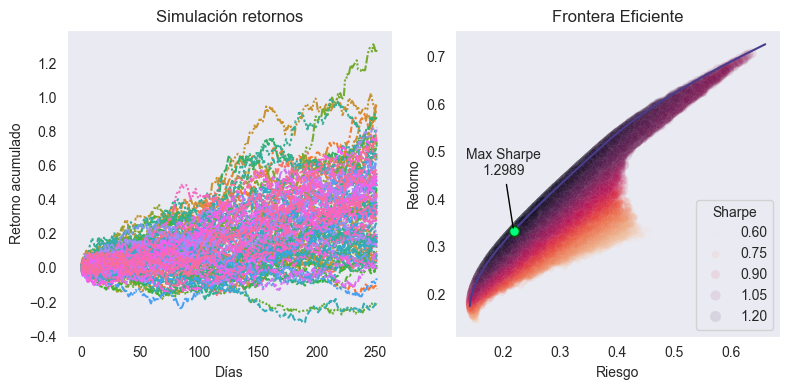

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("dark")

max_sharpe_allocation = pd.DataFrame([max_sharpe_weights], columns=tickers_list).map(lambda w: f"{(100 * w):.2f}%")

print_msg = f"""
# Portafolio óptimo:

{max_sharpe_portfolio.to_string()}

{max_sharpe_allocation.to_string(index=False, justify="left")}

# Simulación:

{simulated_max_sharpe_portfolio.to_string()}
"""

print(print_msg.strip(), "\n")

fig, axes = plt.subplots(1, 2, figsize=(8,4))

sns.lineplot(acc_returns[::200].T, legend=False, ax=axes[0])
axes[0].set_title("Simulación retornos")
axes[0].set_ylabel("Retorno acumulado")
axes[0].set_xlabel("Días")

sns.scatterplot(ax=axes[1], data=simulated_portfolios, x="Riesgo", y="Retorno", hue="Sharpe", size="Sharpe", palette=sns.color_palette("rocket_r", as_cmap=True), linewidth=0.2, alpha=0.1, zorder=0)
axes[1].set_title("Frontera Eficiente")
axes[1].plot("Riesgo", "Retorno", data=ef_line, color="darkslateblue", zorder=1)
axes[1].scatter(max_sharpe_portfolio["Riesgo"], max_sharpe_portfolio["Retorno"], s=50, color="springgreen", edgecolors="darkgreen", zorder=2)
axes[1].annotate(f"Max Sharpe\n{max_sharpe_portfolio["Sharpe"]:.4f}", xy=max_sharpe_portfolio[["Riesgo", "Retorno"]], xytext=(0.2, 0.45), ha="center", arrowprops=dict(arrowstyle="-", facecolor="black", edgecolor="black"), zorder=3)

plt.tight_layout()
plt.show()